In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import galsim
from tqdm import tqdm
from censai.data.cosmos.decode_cosmos import decode_image, preprocess_image, decode_shape
from matplotlib.colors import LogNorm
from astropy.visualization import ImageNormalize, LogStretch
from scipy.signal import tukey
plt.style.use('dark_background')


2021-11-17 23:57:25.775176: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-17 23:57:33.568960: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-17 23:57:33.571692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-17 23:57:33.635300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-17 23:57:33.635323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-17 23:57:33.643694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [7]:
# datapath = os.getenv("CENSAI_PATH") + "/data/cosmos_23.5_finalrun128_train"
datapath = os.getenv("CENSAI_PATH") + "/data/cosmos_23.5_finalrun512_augmented_train"

total_items = int(np.loadtxt(datapath + "/dataset_size.txt"))

files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
# dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE).map(decode_image)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x), block_length=1, num_parallel_calls=tf.data.AUTOTUNE).map(decode_image)


train_set = dataset.take(35000)
train_set = tf.data.Dataset.zip((train_set, train_set)).batch(32)
test_set = dataset.skip(35000)
test_set = tf.data.Dataset.zip((test_set, test_set)).batch(32)

# Denoiser 2021-11-18 (512^2)

In [8]:
denoiser = tf.keras.Sequential()
denoiser.add(tf.keras.Input(shape=[512, 512, 1]))
denoiser.add(tf.keras.layers.Conv2D(filters=16,  kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16,  kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16,  kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
# denoiser.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
# denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=1,  kernel_size=5, padding="same", activation="relu"))
optim = tf.keras.optimizers.Adam(lr=1e-3)
loss = tf.keras.losses.MeanSquaredError()
denoiser.compile(optimizer=optim, loss=loss)
denoiser.fit(train_set, validation_data=test_set, epochs=8, shuffle=False)

Epoch 1/8


2021-11-18 00:02:26.028873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-11-18 00:02:27.662263: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-18 00:02:27.696949: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-11-18 00:02:28.231701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-18 00:02:28.615104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


1094/1094 [==============================] - 246s 212ms/step - loss: 2.7721e-04 - val_loss: 2.7839e-04
Epoch 2/8
 283/1094 [======>.......................] - ETA: 1:13 - loss: 2.7474e-04

KeyboardInterrupt: 

# Denoiser 2021-11-07 (128^2)

In [6]:
denoiser = tf.keras.Sequential()
denoiser.add(tf.keras.Input(shape=[128, 128, 1]))
denoiser.add(tf.keras.layers.Conv2D(filters=16,  kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16,  kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu))
denoiser.add(tf.keras.layers.Conv2DTranspose(filters=1,  kernel_size=5, padding="same", activation="relu"))
optim = tf.keras.optimizers.Adam(lr=1e-3)
loss = tf.keras.losses.MeanSquaredError()
denoiser.compile(optimizer=optim, loss=loss)
denoiser.fit(train_set, validation_data=test_set, epochs=8, shuffle=False)

Epoch 1/8
1094/1094 [==============================] - 39s 34ms/step - loss: 0.0010 - val_loss: 1.6525e-04
Epoch 2/8
1094/1094 [==============================] - 38s 34ms/step - loss: 1.5737e-04 - val_loss: 1.4057e-04
Epoch 3/8
1094/1094 [==============================] - 37s 34ms/step - loss: 1.3714e-04 - val_loss: 1.3215e-04
Epoch 4/8
1094/1094 [==============================] - 37s 34ms/step - loss: 1.2678e-04 - val_loss: 1.2604e-04
Epoch 5/8
1094/1094 [==============================] - 37s 34ms/step - loss: 1.2071e-04 - val_loss: 1.1918e-04
Epoch 6/8
1094/1094 [==============================] - 37s 34ms/step - loss: 1.2322e-04 - val_loss: 1.1553e-04
Epoch 7/8
1094/1094 [==============================] - 37s 34ms/step - loss: 1.1098e-04 - val_loss: 1.0765e-04
Epoch 8/8
1094/1094 [==============================] - 37s 34ms/step - loss: 1.1041e-04 - val_loss: 1.0711e-04


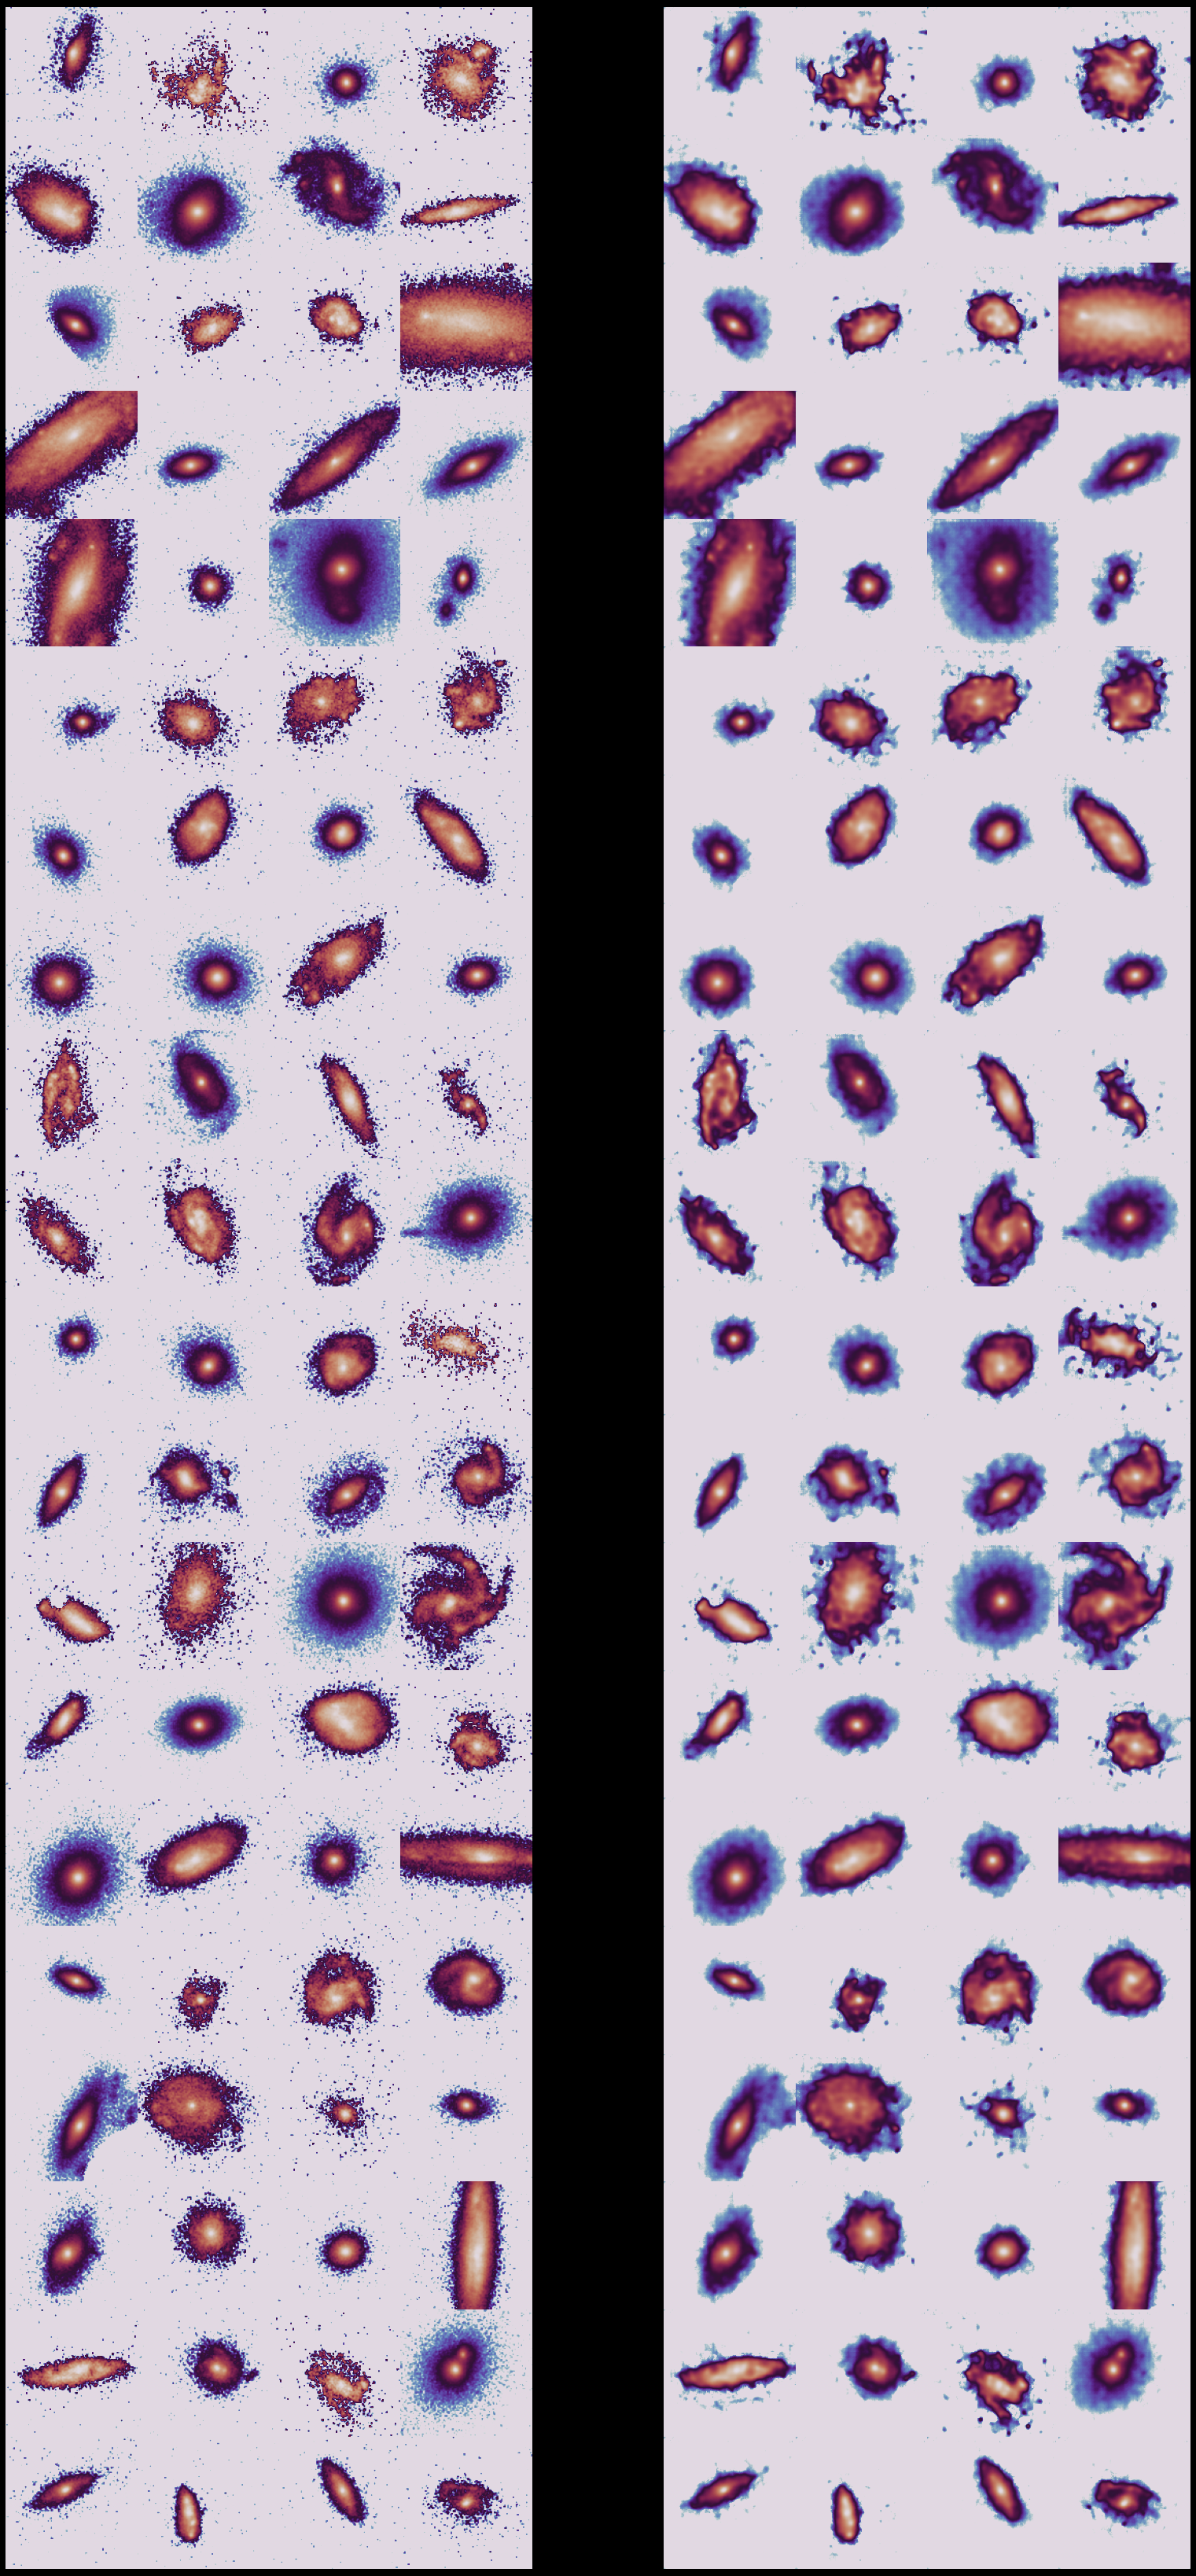

In [14]:

len_y = 20
len_x = 9
fig, axs = plt.subplots(len_y, len_x, figsize=(3 * len_x, 3 * len_y))

images = []
predictions = []
j = 0
for x, y in train_set.skip(300):
    preds = denoiser(x)
    for i in range(x.shape[0]):
        images.append(x[i, ..., 0])
        predictions.append(preds[i, ..., 0])
    j += x.shape[0]
    if j >= len_y * len_x:
        break


for i in range(len_y):
    for j in range(len_x//2):
        k = i + j * len_y
        axs[i, j].imshow(images[k], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4))
        axs[i, j].axis("off")
        
for i in range(len_y):
    for j in range(len_x//2+1):
        if j == 0:
            axs[i, j+len_x//2].axis("off")
            continue
        k = i + (j-1) * len_y
        axs[i, j+len_x//2].imshow(predictions[k], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4))
        axs[i, j+len_x//2].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.05)

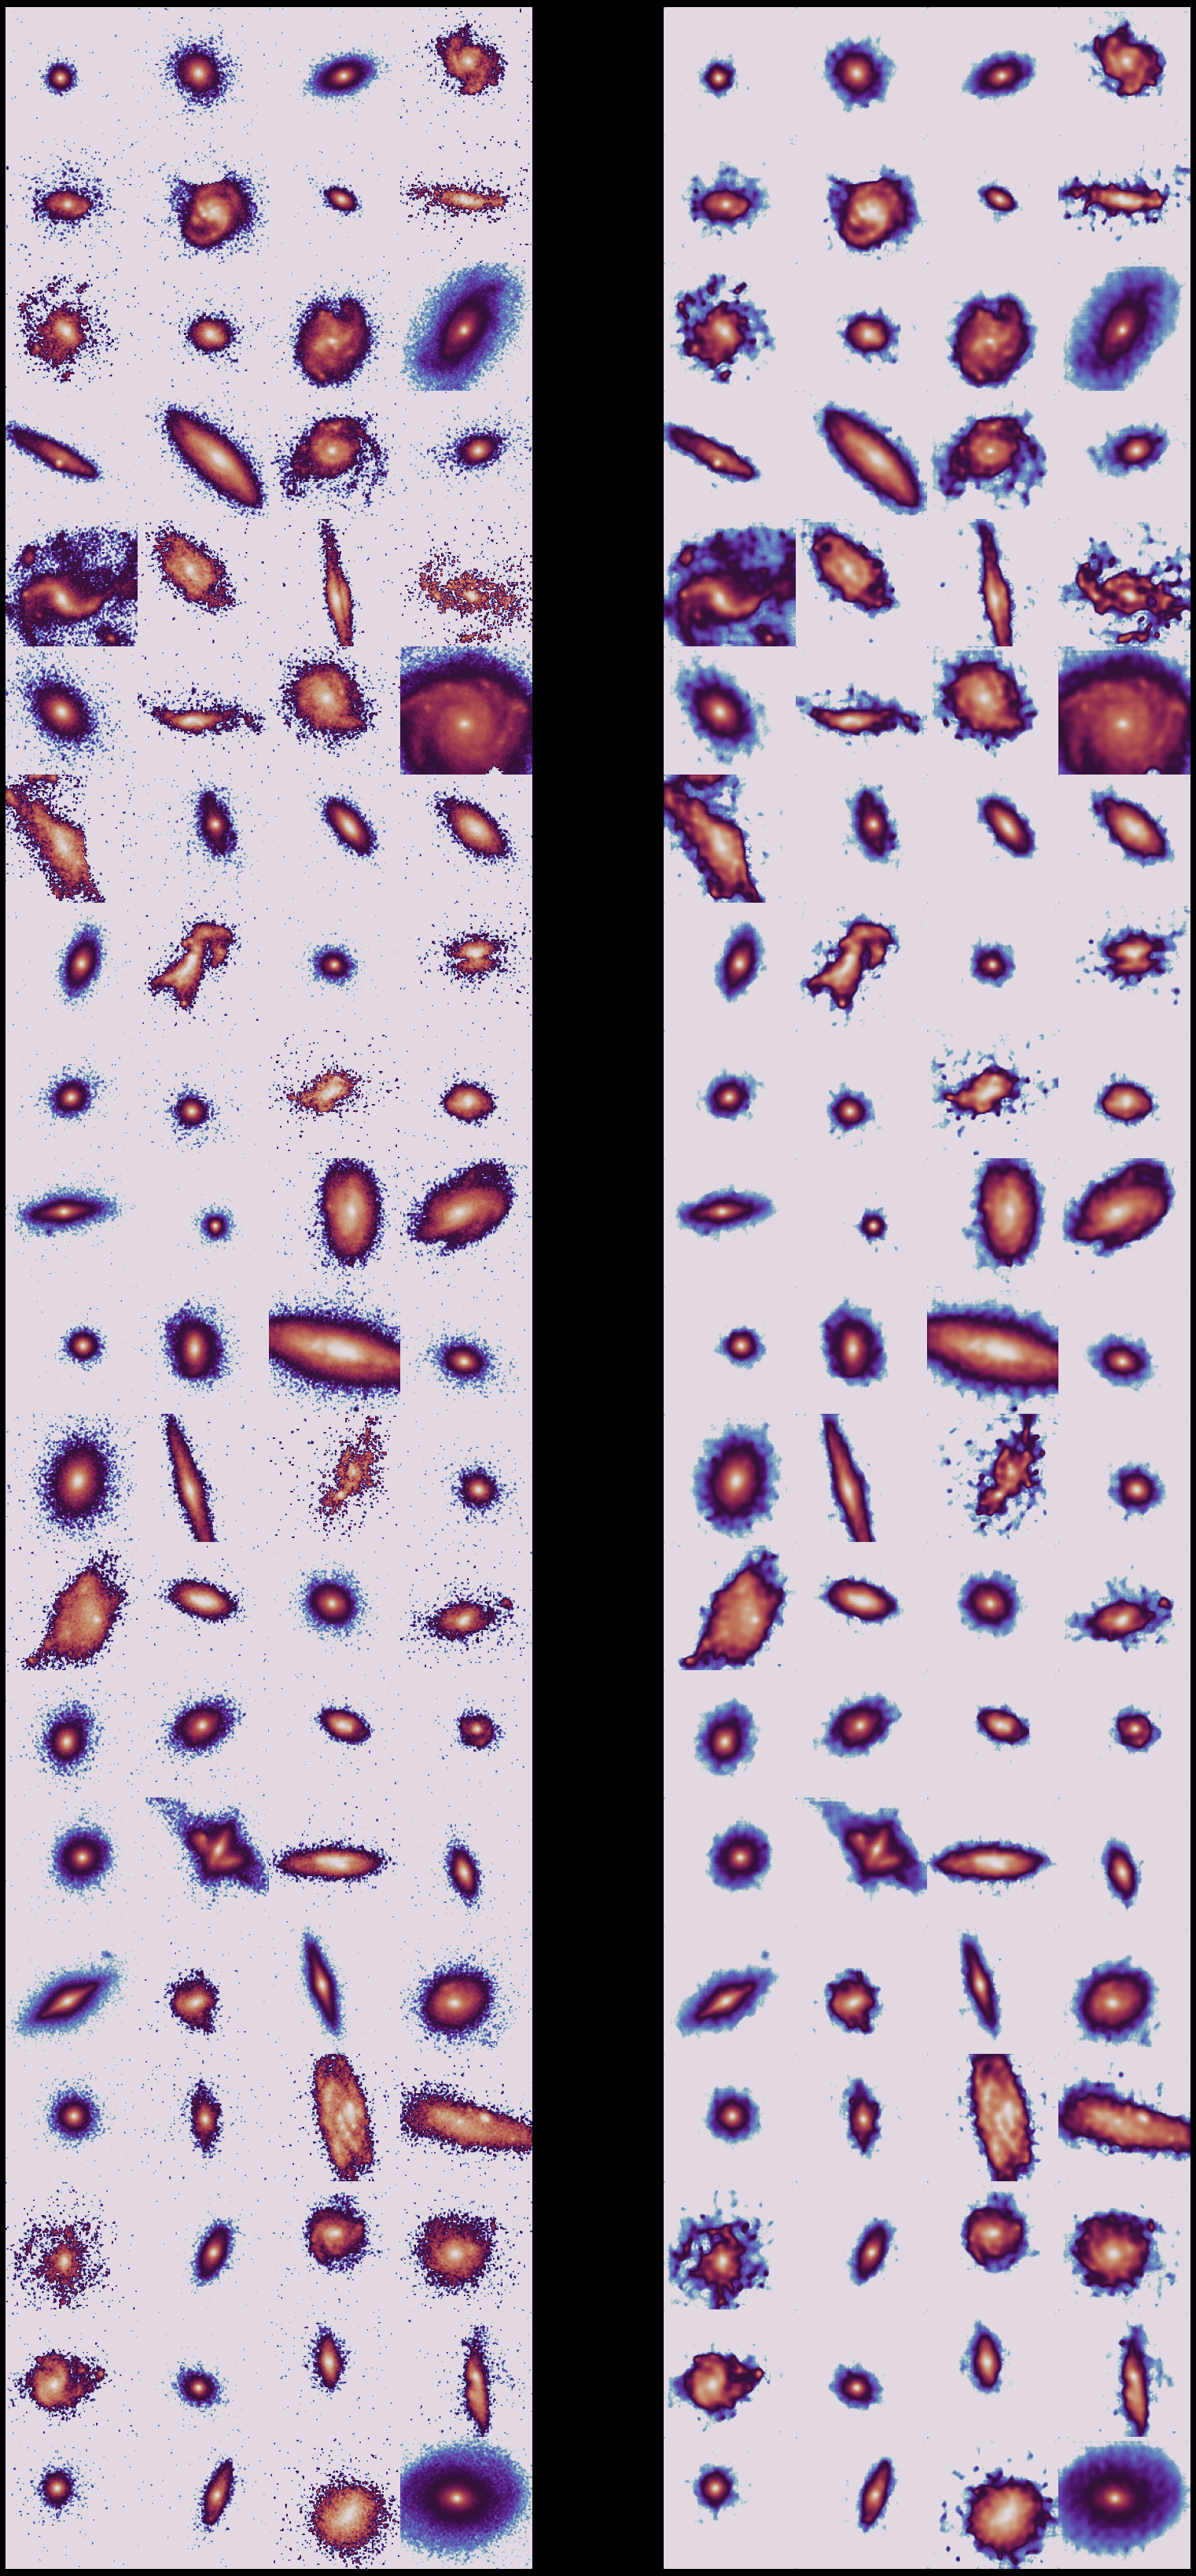

In [58]:

len_y = 20
len_x = 9
fig, axs = plt.subplots(len_y, len_x, figsize=(3 * len_x, 3 * len_y))

images = []
predictions = []
j = 0
for x, y in test_set.skip(400):
    preds = denoiser(x)
    for i in range(x.shape[0]):
        images.append(x[i, ..., 0])
        predictions.append(preds[i, ..., 0])
    j += x.shape[0]
    if j >= len_y * len_x:
        break


for i in range(len_y):
    for j in range(len_x//2):
        k = i + j * len_y
        axs[i, j].imshow(images[k], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4))
        axs[i, j].axis("off")
        
for i in range(len_y):
    for j in range(len_x//2+1):
        if j == 0:
            axs[i, j+len_x//2].axis("off")
            continue
        k = i + (j-1) * len_y
        axs[i, j+len_x//2].imshow(predictions[k], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4))
        axs[i, j+len_x//2].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.05)

# Save denoised dataset

In [16]:
from censai.utils import _bytes_feature, _int64_feature
from tqdm import tqdm

examples_per_shard = 2000
new_datapath = datapath + "_denoised"
if not os.path.isdir(new_datapath):
    os.mkdir(new_datapath)

options = tf.io.TFRecordOptions(compression_type="GZIP")
shards = total_items // examples_per_shard + 1 * (total_items % examples_per_shard > 0)
for shard in tqdm(range(shards)):
    data = dataset.skip(shard * examples_per_shard).take(examples_per_shard)
    with tf.io.TFRecordWriter(os.path.join(new_datapath, f"data_{shard:02d}.tfrecords"), options=options) as writer:
        for x in data.batch(32):
            x_denoised = denoiser(x)
            for b in range(x_denoised.shape[0]):
                im = x_denoised[b, ..., 0].numpy()
                features = {
                    "image": _bytes_feature(im.tobytes()),
                    "height": _int64_feature(im.shape[0]),
                }
                record = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                writer.write(record)


100%|██████████| 24/24 [03:25<00:00,  8.55s/it]


In [40]:
test_datapath = os.getenv("CENSAI_PATH") + "/data/cosmos_23.5_finalrun128_test"
total_items = int(np.loadtxt(test_datapath + "/dataset_size.txt"))

files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE).map(decode_image)

new_datapath = test_datapath + "_denoised"
if not os.path.isdir(new_datapath):
    os.mkdir(new_datapath)

options = tf.io.TFRecordOptions(compression_type="GZIP")
shards = total_items // examples_per_shard + 1 * (total_items % examples_per_shard > 0)
for shard in tqdm(range(shards)):
    data = dataset.skip(shard * examples_per_shard).take(examples_per_shard)
    with tf.io.TFRecordWriter(os.path.join(new_datapath, f"data_{shard:02d}.tfrecords"), options=options) as writer:
        for x in data.batch(32):
            x_denoised = denoiser(x)
            for b in range(x_denoised.shape[0]):
                im = x_denoised[b, ..., 0].numpy()
                features = {
                    "image": _bytes_feature(im.tobytes()),
                    "height": _int64_feature(im.shape[0]),
                }
                record = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                writer.write(record)


100%|██████████| 3/3 [00:12<00:00,  4.05s/it]


# Reconstruction PS

In [19]:
from censai import PowerSpectrum
ps = PowerSpectrum(bins=40, pixels=128)
r = []
for x in tqdm(dataset.batch(32)):
    x_pred = denoiser(x)
    r.append(ps.cross_correlation_coefficient(x[..., 0], x_pred[..., 0]))

1499it [01:50, 13.56it/s]


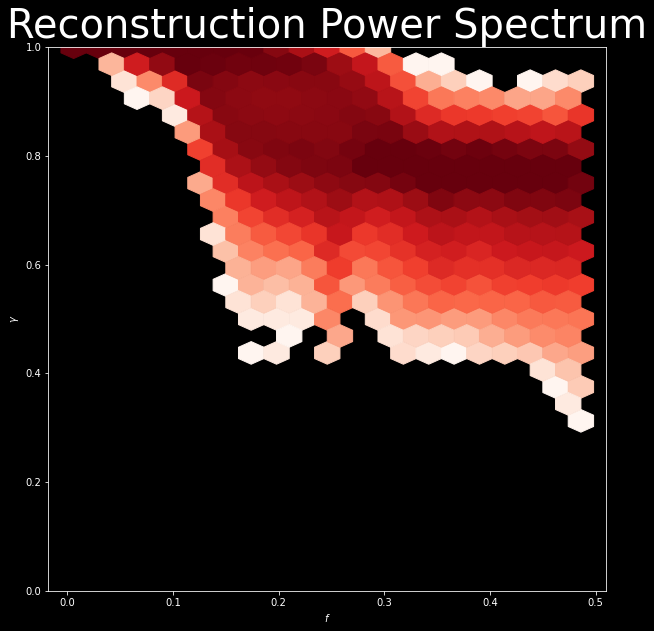

In [38]:
r_concat = np.concatenate(r, axis=0)
pixels = 128
bins = 40

_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:])/2
f = np.tile(f, r_concat.shape[0])

point_cloud = np.stack([r_concat.flatten(), f], axis=1)

plt.figure(figsize=(10, 10))
plt.hexbin(point_cloud[:, 1], point_cloud[:, 0], gridsize=20, cmap='Reds', norm=LogNorm(vmin=1, vmax=20000), mincnt=1)
plt.ylim(0, 1)
plt.title("Reconstruction Power Spectrum", fontsize=40)
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$f$");

# Compare power spectrum

In [41]:
from censai import PowerSpectrum
ps = PowerSpectrum(bins=40, pixels=128)
r_true = []
r_pred = []
for x in tqdm(dataset.batch(32)):
    x_pred = denoiser(x)
    r_true.append(ps.power_spectrum(x[..., 0]))
    r_pred.append(ps.power_spectrum(x_pred[..., 0]))
    


1499it [01:09, 21.67it/s]


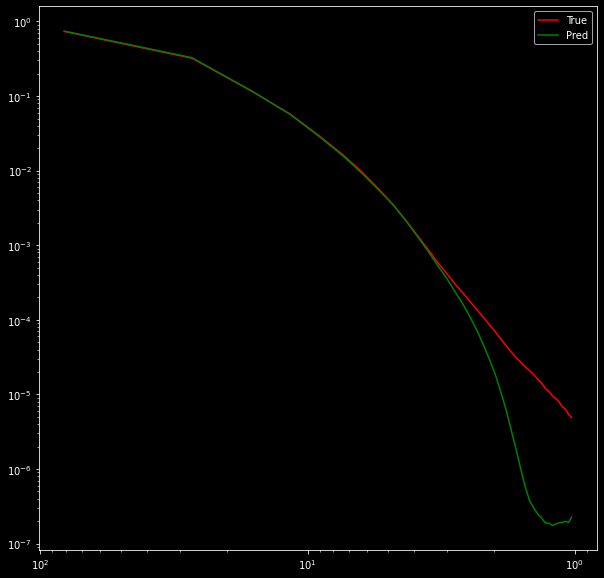

In [55]:
plt.figure(figsize=(10, 10))

r_mean = r_true_c.mean(axis=0)
r_std = r_true_c.std(axis=0)
plt.plot(lam, r_mean, "-", color="r", label=r"True")

r_mean = r_pred_c.mean(axis=0)
r_std = r_pred_c.std(axis=0)
plt.plot(lam, r_mean, "-", color="g", label=r"Pred")
plt.gca().invert_xaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()